# データの中身を見る

In [1]:
# Google　Colaboratory で実行する場合はインストールする
if "google.colab" in str(get_ipython()):
    !pip install japanize_matplotlib
    !pip install seaborn
    !pip install statsmodels

In [2]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats
from statsmodels.tsa import stattools

In [3]:
import os

if os.path.exists("../../stylesheet/k_dm.mplstyle"):
    plt.style.use("../../stylesheet/k_dm.mplstyle")

## データセットの読み込み

In [4]:
data = pd.read_csv("sample.csv")
data.head(10)

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
5,1981-01-06,15.8
6,1981-01-07,15.8
7,1981-01-08,17.4
8,1981-01-09,21.8
9,1981-01-10,20.0


## タイムスタンプをdatetimeにする

Date列は現在Object型、つまり文字列として読み込まれています。これをタイムスタンプとして扱うため、
[datetime --- 基本的な日付型および時間型](https://docs.python.org/ja/3/library/datetime.html)を確認しつつ、datetime型に変換します。

In [5]:
data["Date"] = data["Date"].apply(
    lambda x: datetime.datetime.strptime(str(x), "%Y-%m-%d")
)

print(f"Date列のdtype: {data['Date'].dtype}")

Date列のdtype: datetime64[ns]


## 時系列の概要を確認する

### pandas.DataFrame.describe
はじめに、データがどのようなものであるか簡単に確認します。
[pandas.DataFrame.describe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)を使って、Temp列の簡単な統計量を確認します。

In [6]:
data.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


### 折れ線グラフ
[seaborn.lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html)を使って、どのような周期になっているか確認します。

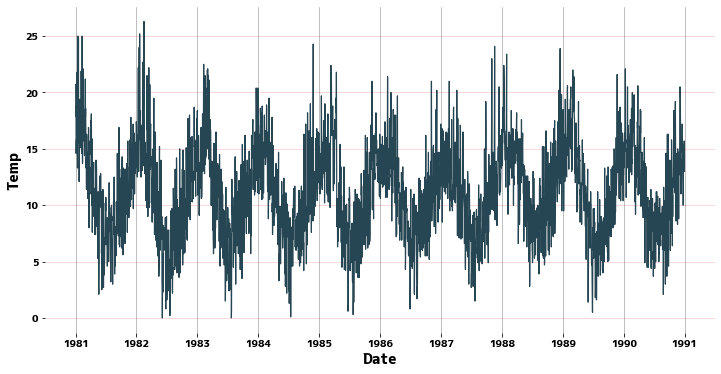

In [7]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=data["Date"], y=data["Temp"])
plt.ylabel("Temp")
plt.grid(axis="x")
plt.grid(axis="y", color="r", alpha=0.3)
plt.show()

### ヒストグラム

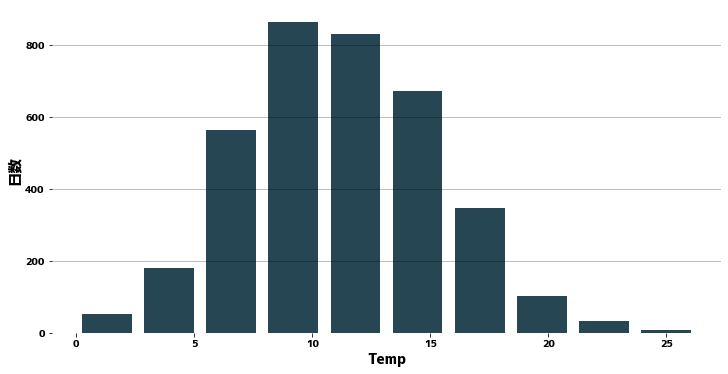

In [8]:
plt.figure(figsize=(12, 6))
plt.hist(x=data["Temp"], rwidth=0.8)
plt.xlabel("Temp")
plt.ylabel("日数")
plt.grid(axis="y")
plt.show()

### 自己相関とコレログラム
[pandas.plotting.autocorrelation_plot](https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html)を用いて自己相関を確認し、時系列データの周期性をチェックします。

> 大雑把に言うと、自己相関とは、信号がそれ自身を時間シフトした信号とどれくらい一致するかを測る尺度であり、時間シフトの大きさの関数として表される。　引用元：[wikipedia - 自己相関](https://ja.wikipedia.org/wiki/%E8%87%AA%E5%B7%B1%E7%9B%B8%E9%96%A2#:~:text=%E8%87%AA%E5%B7%B1%E7%9B%B8%E9%96%A2%EF%BC%88%E3%81%98%E3%81%93%E3%81%9D%E3%81%86%E3%81%8B,%E9%96%A2%E6%95%B0%E3%81%A8%E3%81%97%E3%81%A6%E8%A1%A8%E3%81%95%E3%82%8C%E3%82%8B%E3%80%82)

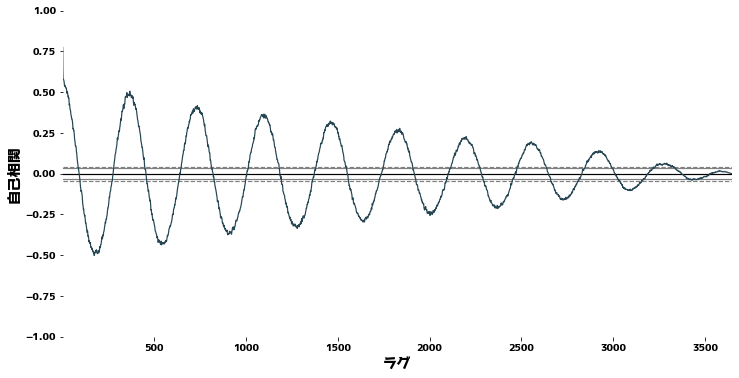

In [9]:
plt.figure(figsize=(12, 6))
pd.plotting.autocorrelation_plot(data["Temp"])
plt.grid()
plt.xlabel("ラグ")
plt.ylabel("自己相関")
plt.show()

### 単位根検定
データが単位根過程であるかどうかを確認します。
単位根過程であることを帰無仮説とする検定（Augmented Dickey-Fuller test）を行います。

[statsmodels.tsa.stattools.adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

In [10]:
stattools.adfuller(data["Temp"], autolag="AIC")

(-4.444804924611697,
 0.00024708263003610177,
 20,
 3629,
 {'1%': -3.4321532327220154,
  '5%': -2.862336767636517,
  '10%': -2.56719413172842},
 16642.822304301197)

### トレンドの確認
1次元多項式を時系列にフィットさせてトレンドの線を引きます。今回のデータはほとんどトレンド定常に近いので、トレンドはほとんどありません。

[numpy.poly1d — NumPy v1.22 Manual](https://numpy.org/doc/stable/reference/generated/numpy.poly1d.html)

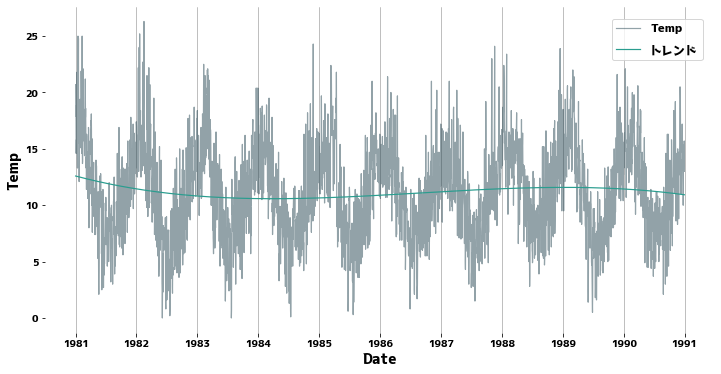

In [11]:
def get_trend(timeseries, deg=3):
    """時系列データのトレンドの線を作成する

    Args:
        timeseries(pd.Series) : 時系列データ。

    Returns:
        pd.Series: トレンドに相当する時系列データ。
    """
    x = list(range(len(timeseries)))
    y = timeseries.values
    coef = np.polyfit(x, y, deg)
    trend = np.poly1d(coef)(x)
    return pd.Series(data=trend, index=timeseries.index)

data["Trend"] = get_trend(data["Temp"])

# グラフをプロット
plt.figure(figsize=(12, 6))
sns.lineplot(x=data["Date"], y=data["Temp"], alpha=0.5, label="Temp")
sns.lineplot(x=data["Date"], y=data["Trend"], label="トレンド")
plt.grid(axis="x")
plt.legend()
plt.show()

#### 補足：トレンドがはっきりとある場合

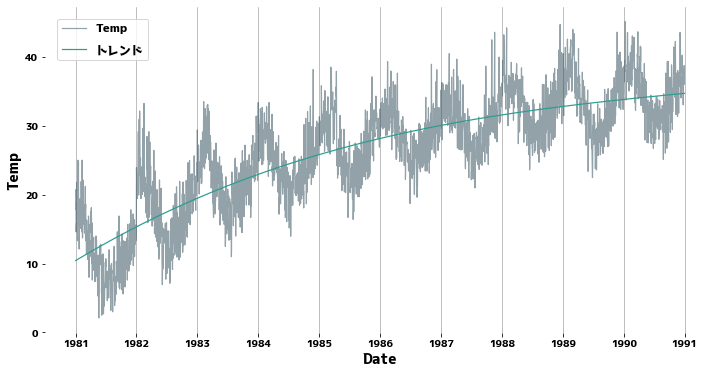

In [12]:
data_sub = data.copy()
data_sub["Temp"] = (
    data_sub["Temp"] + np.log(data_sub["Date"].dt.year - 1980) * 10
)  # ダミーのトレンド
data_sub["Trend"] = get_trend(data_sub["Temp"])

# グラフをプロット
plt.figure(figsize=(12, 6))
sns.lineplot(x=data_sub["Date"], y=data_sub["Temp"], alpha=0.5, label="Temp")
sns.lineplot(x=data_sub["Date"], y=data_sub["Trend"], label="トレンド")
plt.grid(axis="x")
plt.legend()
plt.show()